## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
#### Introduction

I have worked on understanding a data set with A/B test results of an e-commerce website. Goal is to recommend to the company if they should implement new web page design or retain the old one


<a id='probability'></a>
#### Part I - Probability

To get started, let's import required libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

`1.` Now, we are reading in the `ab_data.csv` data and storing it in `df`. 

a. Reading in the dataset and taking a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df[(df['group'] == 'treatment') != (df['landing_page'] == 'new_page')].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum().any()

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. So we drop them.

In [3]:
df3= df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page'))==False].index) 

In [4]:
# Double Check all of the correct rows were removed - this should be 0
df3[((df3['group'] == 'treatment') == (df3['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [10]:
df3.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. Duplicate **user_id**  in **df3**

In [5]:
# row information for the repeat user_id
df3[df3['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c.Row information for the repeat **user_id**? 

In [6]:
#Remove one of the rows with a duplicate user_id
df3.drop(index=2893, inplace=True)

In [1]:
#hecking for duplicate user_ids
df3['user_id'].duplicated().sum()

NameError: name 'df3' is not defined

d. Removing **one** of the rows with a duplicate **user_id**, but keeping  dataframe as **df3**.

In [14]:
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`4.` Probabilities

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df3['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df3.query('group=="control"')['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df3.query('group=="treatment"')['converted'].mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df['landing_page'] == 'new_page').mean()

0.5

In [19]:
#Observed difference between the means of conversion rate in treatment and control group
obs_diff= df3.query('group=="treatment"')['converted'].mean()-df3.query('group=="control"')['converted'].mean()
print(obs_diff)

-0.00157823898536


e. Based on above results,  there is NO sufficient evidence to conclude that the new treatment page leads to more conversions.

Based on above calculations conversion probability for treatment group is lower than control group. Also without calculating the statistical significance using p value we cannot make conclusions about populations based on statistic and hence there is no sufficient evidence to conclude that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test


`1.` We assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, Now we define null and alternative hypotheses in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

H0: p_new - p_old <=0

H1: p_new - p_old > 0

`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

We perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


a. **conversion rate** for $p_{new}$ under the null

In [20]:
p_new=df3['converted'].mean()
print(p_new)

0.119597087245


b. **conversion rate** for $p_{old}$ under the null? 

In [21]:
p_old=df3['converted'].mean()
print(p_old)

0.119597087245


c.  $n_{new}$, the number of individuals in the treatment group

In [22]:
n_new=df3.query('group=="treatment"').shape[0]
print(n_new)

145310


d.  $n_{old}$, the number of individuals in the control group

In [23]:
n_old=df3.query('group=="control"').shape[0]
print(n_old)

145274


e. Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted=np.random.choice([0,1],size=n_new, p=[1-p_new,p_new])
print(new_page_converted)

[0 0 0 ..., 0 0 0]


f. Simulating $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted=np.random.choice([0,1],size=n_old, p=[1-p_old,p_old])
print(new_page_converted)

[0 0 0 ..., 0 0 0]


g.  $p_{new}$ - $p_{old}$ for  simulated values from part (e) and (f).

In [26]:
new_page_converted.mean()-old_page_converted.mean()

-0.00030509539155483545

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process  used in parts (a) through (g) above

In [27]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new]).mean()
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)

Below method can also be used for better efficiency

In [28]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old 
p_diffs = new_converted_simulation - old_converted_simulation

    



i. Plotting a histogram of the **p_diffs**.  

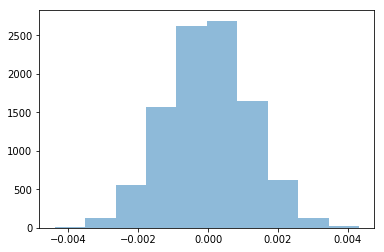

In [29]:
plt.hist(p_diffs, alpha = 0.5);

We would expect the sampling distribution to be normal by the Central Limit Theorem.This looks like what we expected. Here we have simulated draws from the sampling distribution under the null hypothesis.

j. Proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**

In [30]:
(p_diffs>obs_diff).mean()

0.90439999999999998

k. 

As p-value (0.904) computed above is much higher than the chosen significance level (5%) , we fail to reject the null hypothesis. This means that the difference in conversion rates between the new and old pages was not statistically significant enough. So we retain the old page.

l. We could also use a built-in to achieve similar results. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [8]:
import statsmodels.api as sm
from scipy.stats import norm

convert_old = df3.query('landing_page=="old_page"')['converted'].sum()
convert_new = df3.query('landing_page=="new_page"')['converted'].sum()
n_old = df3.query('landing_page=="old_page"').shape[0]
n_new = df3.query('landing_page=="new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m.Using `stats.proportions_ztest` to compute  test statistic and p-value.  

In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative="smaller")
print(z_score)

print(p_value)

1.31092419842
0.905058312759


In [33]:
# define probability 
p = 0.95  
# retrieve critical value <= probability 
cval = norm.ppf(p)
print(cval)

1.64485362695


The p value of 0.905 is statistically insignificant considering it is much higher than our significance level is 0.05. Hence we fail to reject our null hypotheses. Thus we cannot say that the new page has better conversion rate than old page. The z value of 1.31 is less than the critical value (cval) calculated from our confidence interval of 95%. Hence  we can conclude that the difference in conversion rates was not statistically significant enough to reject the null hypothesis. Hence we retain the old page. Yes these findings agree with findings in parts **j.** and **k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` The result achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a.

We should be performing a logistic regression here.

b. The goal is to use **statsmodels** to fit the regression model  specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. We will first  create in df3 a column for the intercept, and create a dummy variable column for which page each user received. Then add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
#importing necessary packages
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [10]:
#Adding dummies for categorical variable landing page and adding an intercept
df3[['ab_page', 'old_page']]=pd.get_dummies(df3['landing_page'])
df3['intercept']=1
df3.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1


c. Using **statsmodels** to instantiate  regression model on the two columns created in part b., then fitting the model using the two columns  created in part **b.** to predict whether or not an individual converts. 

In [11]:
logit_mod=sm.Logit(df3['converted'], df3[['intercept','ab_page']])
results=logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Summary of results

In [12]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 05 Feb 2021   Pseudo R-squ.:               8.077e-06
Time:                        09:54:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. Calculating p-value associated with **ab_page** 

In part 3 Null and alternative hypotheses associated with the regression model are:

H0: b1 = 0

H1: b1 != 0

this is equivalent to testing if

H0: p_new - p_old =0

H1: p_new - p_old != 0

Hence this is a 2 tailed test.

The p value associated with the ab_page- 0.190 is higher than the significance level of 0.05. Hence we fail to reject the null hypotheses which in this case is b1=0. This means that showing the new page or ab_page to visitors does not make any difference to the conversion rate. 

The null and alternative hypotheses in Part II are

H0: p_new - p_old <=0

H1: p_new - p_old > 0


This is a one tailed test. But in both part 2 and part 3 we get the same conclusion that p value is higher than the significance level of 0.05 and we fail to reject the null hypotheses. Hence we reatin the old page

f.Adding additional terms to the regression model

It is useful to consider other variables to ensure that there are no confounding variables that might be affecting the relationship between page and conversion. However the other variable may also cause multicollinearity problem which we need to be wary of.  

g. Along with testing if the conversion rate changes for different pages, we also add an effect based on which country a user lives in. We will read in the **countries.csv** dataset and merge together  datasets on the appropriate rows.  

In [7]:
#Reading countries data set
df_country= pd.read_csv('countries.csv')
print(df_country['country'].unique())
df_country.head()


['UK' 'US' 'CA']


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [8]:
#Merging countries data with ab test data on user_id
mergeddf = pd.merge(left=df3, right=df_country, how='left', left_on='user_id', right_on='user_id')
mergeddf.head()

,user_id,timestamp,group,landing_page,converted,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,US


In [15]:
#Creating dummy varibles for country
mergeddf[['CA', 'UK', 'US']]=pd.get_dummies(mergeddf['country'])
mergeddf['intercept']=1
mergeddf.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,1,US,0,0,1


In [42]:
#instantiating, fitting and summarizing the logistic regression model for CA and US
logit_mod=sm.Logit(mergeddf['converted'], mergeddf[['intercept','CA','US']])
results=logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-02-04 13:51 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
CA           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
US           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

In [43]:
#instantiating, fitting and summarizing the logistic regression model for UK and US
logit_mod=sm.Logit(mergeddf['converted'], mergeddf[['intercept','UK','US']])
results=logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-02-04 13:51 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

We can use np. exp to interpret the coefficients.However here we see in the summary results that the countries have a p value more much higher than the significance level. So the coefficients are not statistically significant.  So we fail to reject the null hypotheses which here is that the coefficients associated with the countries equal to 0. Thus the countries do not make difference on the conversion rate.  

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. 

In [16]:
#Creating logistic regression model with interaction variables for country and page together
mergeddf['CA_ab_page']=mergeddf['CA']* mergeddf['ab_page']
mergeddf['US_ab_page']=mergeddf['US']* mergeddf['ab_page']
logit_mod=sm.Logit(mergeddf['converted'], mergeddf[['intercept','ab_page','CA','US','CA_ab_page','US_ab_page']])
results=logit_mod.fit()
results.summary2()


Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-02-05 09:55 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
CA           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
US            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
CA_ab_page   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
US_ab_page   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

In [38]:
mergeddf.groupby('country').mean()['converted']

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

It is difficult to interpret the coefficients when higher order terms or interaction terms are added. However, as per the p value which is higher than significance level of 0.05 for CA_ab_page and US_ab_page, we fail to reject the null hypotheses which here is that the coefficients associated with the  interaction terms equal to 0. So the way country relates to conversion does not  depend on the ab_page or vice versa.

Here the relationship between conversions and different aspects of time such as weekday/weekend and morning/evening/afternoon/ night are being analyzed using logistic regression. Also the model fit for each model will be analyzed

In [9]:
#Changing datatype of timestamp to datetime 
df3['full_date'] = pd.to_datetime(df3['timestamp'])
df3.dtypes

user_id                  int64
timestamp               object
group                   object
landing_page            object
converted                int64
full_date       datetime64[ns]
dtype: object

In [10]:
#Adding a column with names of week days to df3 dataframe
df3["day"] = df3["full_date"].dt.day_name()

In [11]:
#Mapping the weekday names to 2 categories- weekday and weekend
mapping = {
        'Saturday':'weekend',
        'Sunday':'weekend',
        'Monday':'weekday',
        'Tuesday':'weekday',
        'Wednesday':'weekday',
        'Thursday': 'weekday',
        'Friday': 'weekday'
    }

df3['day'].replace(mapping, inplace=True)

In [13]:
#Creating logistic regression model with weekday/weekend and conversion
df3[['weekday', 'weekend']]=pd.get_dummies(df3['day'])
df3['intercept']=1
df3.head()

,user_id,timestamp,group,landing_page,converted,full_date,day,weekday,weekend,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21 22:11:48.556739,weekend,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12 08:01:45.159739,weekday,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11 16:55:06.154213,weekday,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08 18:28:03.143765,weekend,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21 01:52:26.210827,weekend,0,1,1


In [16]:
# Fitting the above model and showing results summary
logit_mod=sm.Logit(df3['converted'], df3[['intercept','weekday']])
results=logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366121
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.0661
Date:               2021-02-05 19:39 BIC:              212803.2254
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.95925    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9958    0.0109  -182.7276  0.0000  -2.0172  -1.9744
weekday      -0.0007    0.0128    -0.0511  0.9593  -0.0258   0.0245
==================================================================

"""

In [34]:
df3.groupby('day').mean()['converted']

day
weekday    0.119578
weekend    0.119647
Name: converted, dtype: float64

We can use np. exp to interpret the coefficients.However here we see in the summary results that the weekday has a p value 0.959 much higher than the significance level. So the coefficient is not statistically significant.  So we fail to reject the null hypotheses which here is that the coefficients associated with the weekday equal to 0. Thus the weekday/weekend do not make difference on the conversion rate.  

In [20]:
#Adding a column for the hour to df3 dataframe
df3['hour']=df3.full_date.dt.hour
df3.head()

,user_id,timestamp,group,landing_page,converted,full_date,day,weekday,weekend,intercept,hour
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21 22:11:48.556739,weekend,0,1,1,22
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12 08:01:45.159739,weekday,1,0,1,8
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11 16:55:06.154213,weekday,1,0,1,16
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08 18:28:03.143765,weekend,0,1,1,18
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21 01:52:26.210827,weekend,0,1,1,1


In [30]:
# Function to categorize the hour into morning, afternoon, evening and night
def cat(x):
    
    if 6<x<=12:
        return "morning"
    if 12<x<=17:
        return "afternoon"
    if 17<x<21:
        return "evening"
    return "night"


df3['hourcat'] = df3['hour'].apply(lambda x: cat(x))
df3.head()


,user_id,timestamp,group,landing_page,converted,full_date,day,weekday,weekend,intercept,hour,hourcat
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21 22:11:48.556739,weekend,0,1,1,22,night
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12 08:01:45.159739,weekday,1,0,1,8,morning
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11 16:55:06.154213,weekday,1,0,1,16,afternoon
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08 18:28:03.143765,weekend,0,1,1,18,evening
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21 01:52:26.210827,weekend,0,1,1,1,night


In [31]:
#Creating logistic regression model with 'afternoon', 'evening', 'morning','night' and conversion
df3[['afternoon', 'evening', 'morning','night']]=pd.get_dummies(df3['hourcat'])
df3['intercept']=1
df3.head()

,user_id,timestamp,group,landing_page,converted,full_date,day,weekday,weekend,intercept,hour,hourcat,afternoon,evening,morning,night
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21 22:11:48.556739,weekend,0,1,1,22,night,0,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12 08:01:45.159739,weekday,1,0,1,8,morning,0,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11 16:55:06.154213,weekday,1,0,1,16,afternoon,1,0,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08 18:28:03.143765,weekend,0,1,1,18,evening,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21 01:52:26.210827,weekend,0,1,1,1,night,0,0,0,1


In [32]:
#Fitting the above model and summarizing the results
logit_mod=sm.Logit(df3['converted'], df3[['intercept','afternoon', 'evening', 'morning']])
results=logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.5612
Date:               2021-02-05 20:34 BIC:              212824.8798
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.31978    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0083    0.0089  -225.6291  0.0000  -2.0258  -1.9909
afternoon     0.0147    0.0153     0.9572  0.3385  -0.0154   0.0448
evening       0.0226    0.0184     1.2290  0.2191  -0.0135   0.0587
morning       0.0245    0.0144     1.6966  0.0898  -0.0038   0.0528
==================================================================

"""

In [33]:
df3.groupby('hourcat').mean()['converted']

hourcat
afternoon    0.119874
evening      0.120712
morning      0.120914
night        0.118333
Name: converted, dtype: float64

We can use np. exp to interpret the coefficients.However here we see in the summary results that the hour categories afternoon,evening, morning have p values 0.338,0.219, 0.089 much higher than the significance level 0.05. So the coefficients are not statistically significant. So we fail to reject the null hypotheses which here is that the coefficients associated with the hour categories equal to 0. Thus the hour categories do not make difference on the conversion rate.

In [39]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0